# Spin-down power and disk-luminosity evolution

In [1]:
#!/usr/bin/env python3
"""propeller_luminosity_Bdecay.ipynb: a notebook to recreate results of Ronchi et al. (2022)"""

__author__ = "Michele Ronchi"
__copyright__ = "Copyright 2022"
__credits__ = ["Michele Ronchi"]
__license__ = "MIT"
__maintainer__ = "Michele Ronchi"
__email__ = "ronchi@ice.csic.es"

This notebook contains the code to study examples of the spin-period, spin-down power and disk X-ray luminosity evolution of pulsars interacting with a fallback disk in the presence of magnetic field decay (see [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704)). 
We focus on the specific cases of two recently discovered periodic radio sources, the pulsar MTP0013 (Caleb et al. 2022 in press) ($P = 75.9 \, {\rm s}$) and the radio transient GLEAM-X J162759.5-523504.3 ([Hurley-Walker et al. 2022](https://www.nature.com/articles/s41586-021-04272-x)) ($P = 1091 \, {\rm s}$). 
For simplicity we assume that as the neutrons stars reach their observed spin periods in propeller phase, their surrounding disks becomes inactive (i.e. the accretion rate drops to zero) allowing the restoration of ordinary dipolar spin-down. 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy import interpolate
from scipy.integrate import odeint
from scipy.integrate import trapz
from scipy.optimize import curve_fit
from typing import Tuple

import constants as const
import plot_settings

In [3]:
# Characteristic neutron star radius in [cm].
NS_radius = 1.1e6

# Characteristic neutron star mass in solar masses.
NS_mass = 1.4 * const.M_SUN

# Dimensionless coefficients k_0, k_1, k_2 for a force-free magnetosphere
# taken from Spitkovsky (2006) and Philippov et al. (2014).
# For comparison, in vacuum k_0 = 0 and k_1 = k_2 = 2/3.
k_coefficients = [1.0, 1.0, 1.0]

# Canonical neutron star moment of inertia in [g cm^2] assuming a perfect solid sphere.
NS_inertia = 2.0 / 5.0 * NS_mass * NS_radius ** 2

# Auxiliary quantity beta as defined in eq. (72) of Pons & Vigano (2019).
beta = 1./4. * NS_radius ** 6 / (NS_inertia * const.C ** 3)

# Assume an inclination angle in [rad].
chi = 0.

# Incorporate the inclination angle dependence into a constant.
beta_1 = beta * (k_coefficients[0] + k_coefficients[1] * np.sin(chi) ** 2)

# Dominant conductivity based on phonon or impurity scattering, in [1/s].
# For details see Cumming et al. (2004) or Gourgouliatos and Cumming (2014).
sigma = 1e24

# Characteristic length scale of the magnetic field in [cm].
L = 1e5

# Characteristic electron density in [g/cm^3].
n_e = 1e35

# Eddington luminosity assuming Thompson scattering in [erg / s].
L_Edd = 4. * np.pi * const.G * NS_mass * const.M_P * const.C / const.SIGMA_T

# Circularization radius of the disk in [cm].
r_d = 1.e8

# Initial disk central temperature in [K].
T_c = 1.e6

# typical initial viscousity timescale of the disk in [s] see Menou et al. 2001.
t_v = 2080. * (T_c/1.e6)**(-1.) * (r_d/10**8)**(1./2.)

# Maximum time reached by the evolution in [yr].
t_max = 1.e7

# Power-law index for the disk accretion rate decay.
alpha = 1.2

# Power-law index for the disk outer radius evolution.
gamma = 0.44

# Initial spin period of the neutron star in [s].
P_in = 0.01

P_GLEAM = 1091.  # GLEAM-X J162759.5-523504.3 spin period in [s].
P_MTP = 75.9  # MTP0013 spin period in [s].

In [4]:
def timescale_Ohm(L: float, sigma: float) -> float:
    """
    Calculating the ohmic diffusion timescale for a given conductivity and characteristic magnetic
    field length scale. Note that for our purposes, we neglect the fact that both quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the ohmic diffusion process.

    Args:
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        sigma (float): conductivity of the dominating dissipative process, measure in [1/s].

    Returns:
        (float): ohmic diffusion timescale in [yr].
    """

    tau_Ohm = 4 * np.pi * sigma * L ** 2 / (const.C ** 2)
    
    return tau_Ohm


def timescale_Hall(B: float, L: float, n_e: float) -> float:
    """
    Calculating the Hall timescale for a given field strength, characteristic magnetic field length
    scale and electron density. Note that for our purposes, we neglect the fact that all quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the conservative Hall process.
    B will be identified with the initial dipolar magnetic field components at the pulsars' pole.

    Args:
        B (float): (local) magnetic field strength, measured in [G].
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        n_e (float): electron density, measured in [g/cm^3].

    Returns:
        (float): Hall timescale in [yr].
    """

    tau_Hall = (
        4 * np.pi * const.E * n_e * L ** 2 / (const.C * B)
    )

    return tau_Hall


def field_derivative(B: float, B_initial: float) -> float:
    """
    Calculating the change in the magnetic field strength of a pulsar based on a simplified
    differential equation (see eq. (18) of Aguilera et al. (2008)) that captures the
    characteristics of more complicated numerical simulations of pulsar magnetic field
    evolution, i.e., at early timescales the Hall evolution dominates, while at late times
    the exponential magnetic field decay due to Ohmic dissipation kicks in. Note that as
    explained in Aguilera et al. (2008) the Hall timescale corresponds to that of the initial
    field strength.

    Args:
        B (float): pulsar's magnetic field magnitudes evolving with time, measured in [G].
        B_initial (float): pulsar's initial magnetic field magnitudes, measured in [G].

    Returns:
        (float): magnetic field derivatives for a simulated pulsars in [G/yr].
    """

    tau_Ohm = timescale_Ohm(L, sigma)
    tau_Hall = timescale_Hall(B_initial, L, n_e)

    B_deriv = - B / tau_Ohm - B ** 2 / (tau_Hall * B_initial)
    
    return B_deriv

In [5]:
def radius_magnetospheric(B: float, Mdot: float) -> float:
    """
    Magnetospheric radius as a function of the magnetic field of the neutron star and the accretion rate.
    
    Args:
        B (float): value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].
        Mdot (float): inflow rate in [g s^-1].

    Returns:
        (float): magnetosperic radius in [cm].
    """
        
    mu = B * NS_radius**3 / 2.
    
    r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)
        
    return r_m
    

def radius_lc(omega: float) -> float:
    """
    light cylinder radius as a function of the spin frequency.
    
    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): light cylinder radius in [cm].
    """
    
    r_lc = const.C / omega
        
    return r_lc
   
    
def radius_corotation(omega: float) -> float:
    """
    corotation radius as a function of the spin frequency.
    
    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): corotation radius in [cm].
    """
    
    r_cor = ( const.G * NS_mass / (omega ** 2) ) ** (1./3.)
        
    return r_cor

In [6]:
def accretion_rate_Edd_rmag(B: float) -> float:
    """
    Eddington limit of the accretion rate at the magnetospheric radius.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].

    Returns:
        (float): Eddington limit of the accretion rate at the magnetospheric radius in [g s^-1].
    """  
    
    # Magnetic moment.
    mu = B * NS_radius**3 / 2.
    
    Mdot_Edd =  (L_Edd / (const.G * NS_mass)) ** (7./9.) * ( mu ** 4. / (2. * const.G * NS_mass) ) ** (1./9.)
    
    return Mdot_Edd

In [7]:
def accretion_rate_Edd_rlc(omega: float) -> float:
    """
    Eddington limit of the accretion rate at the light cylinder radius.

    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): Eddington limit of the accretion rate at the light cylinder radius in [g s^-1].
    """  
    
    # Light cylinder radius.
    r_lc = radius_lc(omega)
    
    Mdot_Edd = 2 * L_Edd * r_lc / (const.G * NS_mass)
    
    return Mdot_Edd

In [8]:
def disk_accretion_rate_t(Mdot_d0: float, alpha: float, t:float) -> float:
    """                                                          
    Accretion rate inside the disk as a function of time.

    Args:
        Mdot_d0(float): initial maximum disk accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the disk accretion rate. 
        t(float): time in [s]. 

    Returns:
        (float): disk accretion rate in [g s^-1] as a function of time.
    """          
            
    Mdot_d = Mdot_d0 * (1 + t / t_v) ** (-alpha)    
            
    return Mdot_d

In [9]:
def disk_outer_radius_t(t:float) -> float:
    """                                                          
    Accretion rate inside the disk as a function of time.

    Args:
        t(float): time in [s]. 

    Returns:
        (float): disk accretion rate in [g s^-1] as a function of time.
    """          
        
    r_out = r_d * (1 + t / t_v) ** gamma
            
    return r_out

In [10]:
def disk_accretion_rate_in_t(B: float, omega: float, Mdot_d0: float, alpha: float, t:float, t_disrupt: float = None) -> float:
    """
    Accretion rate in the inner boundary of the disk as a function of time.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].
        omega (float): value of the spin frequency measured in [1/s].
        Mdot_d0(float): initial maximum disk accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the disk accretion rate. 
        t(float): time in [s]. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (float): accretion rate at the inner radius of the disk in [g s^-1] as a function of time.
    """ 
    
    # Compute Eddington limits on the accretion rate [g s^-1]
    Mdot_Edd_mag = accretion_rate_Edd_rmag(B)
    Mdot_Edd_lc = accretion_rate_Edd_rlc(omega)
    
    # The disk inner radius is the smaller between the magnetospheric radius and the light cylinder radius.
    Mdot_Edd = min(Mdot_Edd_mag, Mdot_Edd_lc)

    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = 0.
    
    # Limit the accretion rate at the inner disk edge to the Eddington limit.
    if Mdot_d < Mdot_Edd:
        Mdot_din = Mdot_d
    elif Mdot_d >= Mdot_Edd:
        Mdot_din = Mdot_Edd
    
    # When the disk is disrupted because r_in > r_out set the accretion rate to 0 afterwords.
    if (t_disrupt is not None):
        if (t > t_disrupt):
            Mdot_din = 0.

    return Mdot_din

In [11]:
def disk_accretion_rate_in_t_numpy(B: float, omega: np.ndarray, Mdot_d0: float, alpha: float, t:np.array, t_disrupt: float = None) -> float:
    """
    Accretion rate in the inner boundary of the disk as a function of time optimized for numpy array.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].
        omega (np.ndarray): value of the spin frequency measured in [1/s].
        Mdot_d0(float): initial maximum fallback rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the inflow rate. 
        t(np.ndarray): time in [s]. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (np.ndarray): fall back accretion rate in [g s^-1] as a function of time.
    """      
    
    # Compute Eddington limits on the accretion rate [g s^-1].
    Mdot_Edd_mag = accretion_rate_Edd_rmag(B)
    Mdot_Edd_lc = accretion_rate_Edd_rlc(omega)
    
    # The disk inner radius is the smaller between the magnetospheric radius and the light cylinder radius.
    Mdot_Edd = np.minimum(Mdot_Edd_mag, Mdot_Edd_lc)

    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = np.zeros(len(t))
                   
    # Limit the accretion rate at the inner disk edge to the Eddington limit.
    Mdot_din[Mdot_d >= Mdot_Edd] = Mdot_Edd[Mdot_d >= Mdot_Edd]
    Mdot_din[Mdot_d < Mdot_Edd] = Mdot_d[Mdot_d < Mdot_Edd]
       
    # When the disk is disrupted because r_in > r_out set the accretion rate to 0 afterwords.
    if t_disrupt is not None:
        Mdot_din[t > t_disrupt] = 0.
    
    return Mdot_din

In [12]:
def omega_keplerian(r: float) -> float:
    """
    keplerian orbital frequency as a function of the radius.
    
    Args:
        r (float): distance from the star in [cm].

    Returns:
        (float): keplerian orbital frequency in [1/s].
    """
    
    omega_k = ( const.G * NS_mass / (r ** 3) ) ** (1./2.)
        
    return omega_k

In [13]:
def derivatives_spin_evolution(t:float, initial_cond:np.ndarray, B0:float, Mdot_d0:float, alpha:float, t_disrupt: float = None) -> float:
    """
    Derivative of the magnetic field and spin frequency for the three phases, direct accretion, propeller and ejector.
    See Metzger et al. (2018).

    Args:
        t(float): time variable in [s],
        initial_cond(np.ndarray): current value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G] and value of the spin frequency measured omega in [1/s].
        B0 (float): initial value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].
        Mdot_d0 (float): accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate.   
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (float): Derivative of the magnetic field and spin frequency for the three phases, direct accretion, propeller and ejector [s^-2].
    """    
    B = initial_cond[0]
    omega = initial_cond[1]
    
    Bdot = field_derivative(B, B0)
    
    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = disk_accretion_rate_in_t(B, omega, Mdot_d0, alpha, t, t_disrupt)
    
    r_m = radius_magnetospheric(B, Mdot_din)
    r_c = radius_corotation(omega)
    r_lc = radius_lc(omega)          
    
    omega_k_rns = omega_keplerian(NS_radius)
    omega_k_rm = omega_keplerian(r_m)
    omega_k_rlc = omega_keplerian(r_lc)
    
    omegadot = 0.
        
    if (r_m <= NS_radius):
        # direct accretion phase with likely buried magnetic field.
        omegadot = Mdot_din * NS_radius ** 2 / NS_inertia * (omega_k_rns - omega) - (r_lc/NS_radius)**2 * beta_1 * B**2 * omega ** 3
        
    elif (r_m > NS_radius) & (r_m < r_lc):
        # propeller (r_m > r_c) or direct accretion phase (r_m < r_c).
        omegadot = Mdot_din * r_m ** 2 / NS_inertia * (omega_k_rm - omega) - (r_lc/r_m)**2 * beta_1 * B**2 * omega ** 3
    
    elif (r_m >= r_lc):
        # Ejector phase.
        omegadot = Mdot_din * r_lc ** 2 / NS_inertia * (omega_k_rlc - omega) - beta_1 * B**2 * omega ** 3
        
    derivatives = np.array([Bdot, omegadot])
    
    return derivatives

In [14]:
def omegadot_numpy(t:np.ndarray, omega:np.ndarray, B:np.ndarray, Mdot_d0:float, alpha:float, t_disrupt: float = None) -> float:
    """
    Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector optimized for numpy arrays.
    See Metzger et al. (2018).

    Args:
        t(np.ndarray): time variable in [s],
        omega (np.ndarray): value of the spin frequency measured in [1/s].
        B (np.ndarray): value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G] as a function of time.
        Mdot (float): accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (np.ndarray): Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector [s^-2].
    """      
    
    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = disk_accretion_rate_in_t_numpy(B, omega, Mdot_d0, alpha, t, t_disrupt)
    
    r_m = radius_magnetospheric(B, Mdot_din)
    r_c = radius_corotation(omega)
    r_lc = radius_lc(omega)
    
    omegadot = np.zeros(len(t))
        
    omega_k_rns = omega_keplerian(NS_radius)
    omega_k_rm = omega_keplerian(r_m)
    omega_k_rlc = omega_keplerian(r_lc)
    
    cond_acc = (r_m <= NS_radius)
    cond_prop_acc = (r_m > NS_radius) & (r_m < r_lc)
    cond_ej = (r_m >= r_lc)
    
    omegadot[cond_acc] = Mdot_din[cond_acc] * NS_radius ** 2 / NS_inertia * (omega_k_rns - omega[cond_acc]) - (r_lc[cond_acc]/NS_radius)**2 * beta_1 * B[cond_acc]**2 * omega[cond_acc] ** 3
    omegadot[cond_prop_acc] = Mdot_din[cond_prop_acc] * r_m[cond_prop_acc] ** 2 / NS_inertia * (omega_k_rm[cond_prop_acc] - omega[cond_prop_acc]) - (r_lc[cond_prop_acc]/r_m[cond_prop_acc])**2 * beta_1 * B[cond_prop_acc]**2 * omega[cond_prop_acc] ** 3
    omegadot[cond_ej] = Mdot_din[cond_ej] * r_lc[cond_ej] ** 2 / NS_inertia * (omega_k_rlc[cond_ej] - omega[cond_ej]) - beta_1 * B[cond_ej]**2 * omega[cond_ej] ** 3
     
    return omegadot

In [15]:
def rotational_evolution(
    B0: float,
    P_initial: float,
    Mdot_d0: float,
    alpha: float,
    t_max: float,
    P_stop: float = None,
) -> Tuple[
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    bool,
    bool,
    float,
]:
    """
    Evolving the neutron stars' spin period in case of interaction with a fall-back disk.

    Args:
        B0 (float): initial value of the magnetic field magnitude, measured in [G].
        P_initial (float): pulsars' initial rotation periods, measured in [s].
        Mdot_d0 (float): initial accretion rate at the beginning of fall-back in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate. 
        t_max (float): maximum time for the evolution in [yr].
        P_stop (float): spin period in [s] at which the Mdot evolution is truncated.

    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
        np.ndarray, np.ndarray, bool, bool, float): time array in [yr], spin period as a 
        function of time in [s], derivative of the spin period in [s/s], magnetic field as 
        a function of time in [G], 
    """

    # Define the time grid in s.
    t_max = t_max * const.YR_TO_S
    time_grid = np.logspace(np.log10(10.0), np.log10(t_max), 2000)

    # Set the initial conditions.
    omega_initial = 2.0 * np.pi / P_initial

    initial_conditions = np.array([B0, omega_initial])

    # Evolve in time.
    evol_output = np.array(
        odeint(
            derivatives_spin_evolution,
            y0=initial_conditions,
            t=time_grid,
            args=(B0, Mdot_d0, alpha,),
            tfirst=True,
        )
    )

    # Extract the evolution output for B and omega.
    B_t = np.array(evol_output[:, 0].tolist())
    omega_t = np.array(evol_output[:, 1].tolist())

    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, time_grid)
    Mdot_din = disk_accretion_rate_in_t_numpy(B_t, omega_t, Mdot_d0, alpha, time_grid)

    r_m = radius_magnetospheric(B_t, Mdot_din)
    r_lc = radius_lc(omega_t)

    # Compute the inner and outer radius of the disk.
    r_in = np.minimum(r_m, r_lc)
    r_out = disk_outer_radius_t(time_grid)

    # Check if the field could be buried in the initial stages (before the field decays 
    # on a Ohmic timescale ~10^6 yr).
    buried = False
    if np.min(r_m[time_grid / const.YR_TO_S < 10 ^ 6]) < NS_radius:
        buried = True
        print("buried:", buried)

    # If the period at which we want the disk to be disrupted is surpassed, disrupt the disk.
    disk_disrupted = False
    t_disrupt = None
    if any(omega_t < 2 * np.pi / P_stop):
        disk_disrupted = True
        t_disrupt = time_grid[omega_t < 2 * np.pi / P_stop]
        t_disrupt = t_disrupt[0]

        # Re-run the evolution considering the time when the disk should be disrupted.
        evol_output = np.array(
            odeint(
                derivatives_spin_evolution,
                y0=initial_conditions,
                t=time_grid,
                args=(B0, Mdot_d0, alpha, t_disrupt),
                tfirst=True,
            )
        )

        print("disk disrupted:", disk_disrupted)

    omega_t = np.array(evol_output[:, 1].tolist())
    P_t = 2 * np.pi / omega_t

    omegadot_t = omegadot_numpy(time_grid, omega_t, B_t, Mdot_d0, alpha, t_disrupt)
    Pdot_t = -(P_t ** 2) / (2.0 * np.pi) * omegadot_t

    Mdot_din = disk_accretion_rate_in_t_numpy(
        B_t, omega_t, Mdot_d0, alpha, time_grid, t_disrupt
    )

    r_m = radius_magnetospheric(B_t, Mdot_din)
    r_c = radius_corotation(omega_t)
    r_lc = radius_lc(omega_t)

    # Estimate the accretion X-ray luminosity in [erg/s].
    L_x = np.zeros(len(time_grid))
    L_x[r_m < r_lc] = 0.5 * const.G * NS_mass * Mdot_din[r_m < r_lc] / r_m[r_m < r_lc]
    L_x[r_m >= r_lc] = (
        0.5 * const.G * NS_mass * Mdot_din[r_m >= r_lc] / r_lc[r_m >= r_lc]
    )

    # Evaluate the spin-down power in [erg/s].
    Erot_dot = -NS_inertia * omega_t * omegadot_t

    return (
        time_grid / const.YR_TO_S,
        P_t,
        Pdot_t,
        B_t,
        r_m,
        r_c,
        r_lc,
        Mdot_d,
        Mdot_din,
        buried,
        disk_disrupted,
        t_disrupt,
        L_x,
        Erot_dot,
    )

/tmp/ipykernel_31892/4249457180.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)
/tmp/ipykernel_31892/4249457180.py:16: RuntimeWarning: divide by zero encountered in true_divide
  r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)
/tmp/ipykernel_31892/4249457180.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)
/tmp/ipykernel_31892/4249457180.py:16: RuntimeWarning: divide by zero encountered in true_divide
  r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)


disk disrupted: True
disk disrupted: True


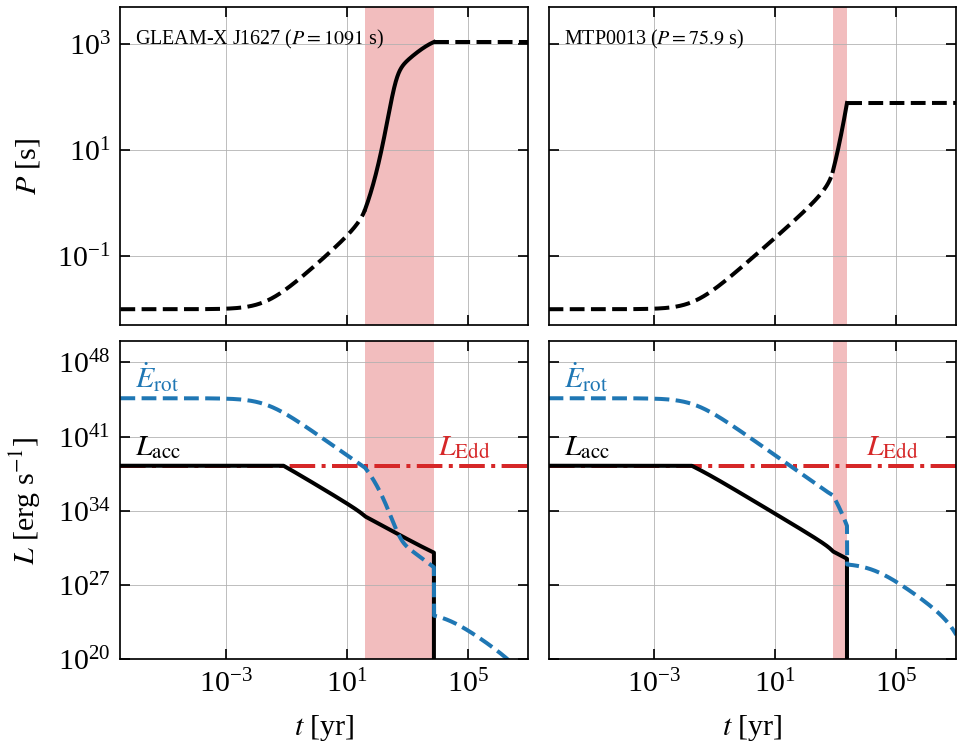

In [16]:
# Plot an example of the spin-period evolution together with the spin-down power 
# and the expected disk luminosity.
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for ax in axs.flat:
    ax.set(xscale="log", yscale="log")
    ax.grid()
    ax.label_outer()

time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _, L_x, Erot_dot = rotational_evolution(
    4.0e14, P_in, 1.0e24, alpha, t_max, P_stop=P_GLEAM
)
t_prop = time[(r_m < r_lc)]
t_prop_in = t_prop[0]
t_prop_end = t_prop[t_prop < 1.0e6]
t_prop_end = t_prop_end[-1]

mask1 = r_m >= r_lc
mask2 = r_m < r_lc

axs[0, 0].set(xlabel=r"$t$ [yr]", ylabel=r"$P$ [s]")
axs[0, 0].set(xlim=(10 / const.YR_TO_S, t_max), ylim=(5.0e-3, 5.0e3))

axs[0, 0].plot(
    np.ma.masked_where(mask1, time),
    np.ma.masked_where(mask1, P),
    color="black",
    linestyle="-",
    linewidth=4,
    rasterized=True,
)
axs[0, 0].plot(
    np.ma.masked_where(mask2, time),
    np.ma.masked_where(mask2, P),
    color="black",
    linestyle="--",
    linewidth=4,
    rasterized=True,
)
axs[0, 0].axvspan(
    xmin=t_prop_in, xmax=t_prop_end, facecolor="tab:red", alpha=0.3, rasterized=True,
)
axs[0, 0].text(
    1.0e-6, 1.0e3, r"GLEAM-X J1627 ($P=1091$ s)", fontsize=20, rotation=0, color="black"
)

axs[1, 0].set(xlabel=r"$t$ [yr]", ylabel=r"$L$ [erg s$^{-1}$]")
axs[1, 0].set(xlim=(10 / const.YR_TO_S, t_max), ylim=(1.0e20, 1.0e50))
axs[1, 0].axhline(
    y=L_x[0], color="tab:red", linestyle="-.", linewidth=4, rasterized=True,
)
axs[1, 0].plot(
    time, L_x, linestyle="-", linewidth=4, color="black",
)
axs[1, 0].plot(
    time, Erot_dot, linestyle="--", linewidth=4, color="tab:blue",
)
axs[1, 0].axvspan(
    xmin=t_prop_in, xmax=t_prop_end, facecolor="tab:red", alpha=0.3, rasterized=True,
)
axs[1, 0].text(
    1.0e-6,
    Erot_dot[0] * 1.0e1,
    r"$\dot{E}_{\rm rot}$",
    fontsize=30,
    rotation=0,
    color="tab:blue",
)
axs[1, 0].text(
    1.0e-6, L_x[0] * 1.0e1, r"$L_{\rm acc}$", fontsize=30, rotation=0, color="black"
)
axs[1, 0].text(
    1.0e4, L_x[0] * 1.0e1, r"$L_{\rm Edd}$", fontsize=30, rotation=0, color="tab:red"
)

time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _, L_x, Erot_dot = rotational_evolution(
    4e14, P_in, 1.0e23, alpha, t_max, P_stop=P_MTP
)
t_prop = time[(r_m < r_lc)]
t_prop_in = t_prop[0]
t_prop_end = t_prop[-1]

mask1 = r_m >= r_lc
mask2 = r_m < r_lc

axs[0, 1].set(xlabel=r"$t$ [yr]", ylabel=r"$P$ [s]")
axs[0, 1].set(xlim=(10 / const.YR_TO_S, t_max), ylim=(5.0e-3, 5.0e3))

axs[0, 1].plot(
    np.ma.masked_where(mask1, time),
    np.ma.masked_where(mask1, P),
    color="black",
    linestyle="-",
    linewidth=4,
    rasterized=True,
)
axs[0, 1].plot(
    np.ma.masked_where(mask2, time),
    np.ma.masked_where(mask2, P),
    color="black",
    linestyle="--",
    linewidth=4,
    rasterized=True,
)
axs[0, 1].axvspan(
    xmin=t_prop_in, xmax=t_prop_end, facecolor="tab:red", alpha=0.3, rasterized=True,
)
axs[0, 1].text(
    1.0e-6, 1.0e3, r"MTP0013 ($P=75.9$ s)", fontsize=20, rotation=0, color="black"
)

axs[1, 1].set(xlabel=r"$t$ [yr]", ylabel=r"$L$ [erg s$^{-1}$]")
axs[1, 1].set(xlim=(10 / const.YR_TO_S, t_max), ylim=(1.0e20, 1.0e50))
axs[1, 1].axhline(
    y=L_x[0], color="tab:red", linestyle="-.", linewidth=4, rasterized=True,
)
axs[1, 1].plot(
    time, L_x, linestyle="-", linewidth=4, color="black",
)
axs[1, 1].plot(
    time, Erot_dot, linestyle="--", linewidth=4, color="tab:blue",
)
axs[1, 1].axvspan(
    xmin=t_prop_in, xmax=t_prop_end, facecolor="tab:red", alpha=0.3, rasterized=True,
)
axs[1, 1].text(
    1.0e-6,
    Erot_dot[0] * 1.0e1,
    r"$\dot{E}_{\rm rot}$",
    fontsize=30,
    rotation=0,
    color="tab:blue",
)
axs[1, 1].text(
    1.0e-6, L_x[0] * 1.0e1, r"$L_{\rm acc}$", fontsize=30, rotation=0, color="black"
)
axs[1, 1].text(
    1.0e4, L_x[0] * 1.0e1, r"$L_{\rm Edd}$", fontsize=30, rotation=0, color="tab:red"
)

fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

for ax in axs.flat:
    ax.label_outer()

# fig.savefig("GLEAM_MTP_luminosity_Bdecay.pdf", bbox_inches="tight")
plt.show()